### Section 1: Load headers

** Tried with balanced class weights **

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import matplotlib.pyplot as plt

from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn import metrics

from sklearn.preprocessing import LabelBinarizer
import seaborn as sns

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from sklearn.utils import class_weight

Using TensorFlow backend.


### Section 2: Load training data and target label

In [ ]:
path = ''
data = pd.read_excel('..\data\classwise_train\pneumonia.xlsx')

In [ ]:
data.shape

(27608, 6)

#### Section 2.a : Loading data from images and converting into numpy

In [ ]:
orig_path = 'CheXpert-v1.0-small'
opath_len = len(orig_path)
train_image = []
for image_path in data['Path'][:10000]:
    #print('../data' + image_path[opath_len:])
    img = image.load_img('../data' + image_path[opath_len:],target_size=(250,250,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
    
train_data = np.array(train_image)

In [ ]:
train_data.shape

(10000, 250, 250, 3)

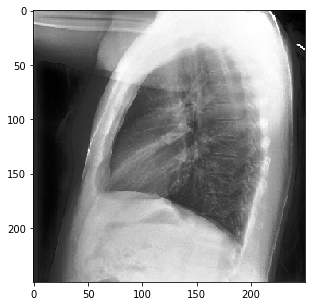

In [ ]:
rcParams['figure.figsize'] = 5, 5
plt.imshow(train_data[11])

In [ ]:
target_label = np.array(data[:10000].drop(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA'],axis=1).fillna(0))

In [ ]:
target_label.shape

(10000, 1)

In [ ]:
np.unique(target_label, return_counts=True)

(array([-1,  0,  1], dtype=int64), array([6498, 1176, 2326], dtype=int64))

**Question to address, what to do with -1 class, drop? or combine with 0?**

In [ ]:
target_label[target_label<0] = 0
np.unique(target_label, return_counts=True)

(array([0, 1], dtype=int64), array([7674, 2326], dtype=int64))

#### Section 2.b: Dividing data into train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data, target_label, random_state=42, test_size=0.1)

In [ ]:
np.unique(y_train)

array([0, 1], dtype=int64)

In [ ]:
y_train.ravel()

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [ ]:
# Clearing out memory
train_data = []
target_label = []
# Calculate the weights for each class so that we can balance the data
weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train.ravel())
print(weights)

[0.64953811 2.17181467]


In [ ]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1], dtype=int64), array([6928, 2072], dtype=int64))
(array([0, 1], dtype=int64), array([746, 254], dtype=int64))


In [ ]:
y_train = to_categorical(y_train.ravel())
y_test = to_categorical(y_test.ravel())

### Section 3 : Defining the model

In [ ]:
num_classes = 2 ## For 1, 0 , -1
## CNN model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(250,250,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))
#model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 246, 246, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 123, 123, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 119, 119, 32)      12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 59, 59, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 55, 55, 64)        51264     
__________

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
callbacks_list = [early_stop, reduce_lr]

#### Section 4: Training the model

In [ ]:
model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 10, callbacks = callbacks_list, validation_data = (X_test, y_test), class_weight=weights)

Instructions for updating:
Use tf.cast instead.
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 50s 6ms/step - loss: 0.5668 - acc: 0.7681 - val_loss: 0.5662 - val_acc: 0.7460
Epoch 2/10
9000/9000 [==============================] - 26s 3ms/step - loss: 0.5557 - acc: 0.7698 - val_loss: 0.5672 - val_acc: 0.74605566 
Epoch 3/10
9000/9000 [==============================] - 27s 3ms/step - loss: 0.5478 - acc: 0.7698 - val_loss: 0.5665 - val_acc: 0.7460A  - ETA: 1s - loss: 0.5
Epoch 4/10
9000/9000 [==============================] - 27s 3ms/step - loss: 0.5430 - acc: 0.7698 - val_loss: 0.5658 - val_acc: 0.7460
Epoch 5/10
9000/9000 [==============================] - 27s 3ms/step - loss: 0.5426 - acc: 0.7698 - val_loss: 0.5671 - val_acc: 0.7460A: 1s - loss: 0.5436 
Epoch 6/10
9000/9000 [==============================] - 27s 3ms/step - loss: 0.5429 - acc: 0.7698 - val_loss: 0.5669 - val_acc: 0.746026 - acc: 0
Epoch 7/10
9000/9000 [===========

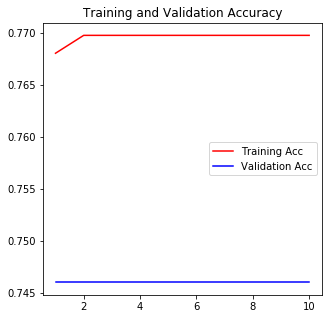

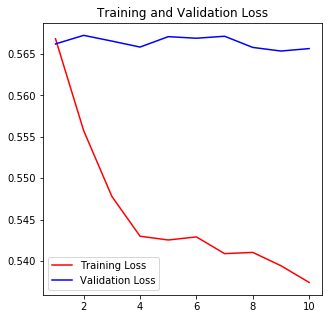

In [ ]:
train_acc = model.history.history['acc']
train_loss = model.history.history['loss']
val_acc = model.history.history['val_acc']
val_loss = model.history.history['val_loss']

epochs = range(1, len(train_acc)+1)

plt.plot(epochs, train_acc, 'r', label = 'Training Acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
plt.plot(epochs, train_loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Section 5: Predicting from valid data

In [ ]:
test_data = np.load('../../numpy_weights/valid_test_data.npy')

In [ ]:
path = ''
valid_data = pd.read_csv(path + '../data/valid.csv')
valid_data.columns

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices'],
      dtype='object')

In [ ]:
test_label = np.array(valid_data.drop(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA'],axis=1).fillna(0))
ec_test_label = test_label[:,7:8]
print(valid_data.columns[5+7:6+7])
print(ec_test_label.shape)
np.unique(ec_test_label, return_counts=True)

Index(['Pneumonia'], dtype='object')
(234, 1)


(array([0., 1.]), array([226,   8], dtype=int64))

In [ ]:
y_orig = to_categorical(ec_test_label.ravel())
print(y_orig.shape)
pred = model.predict(test_data)
y_pred = np.where(pred > 0.5, 1.0, 0.0)

(234, 2)


### Section 6: Performance Evaluation Metrics

In [ ]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
        lb = LabelBinarizer()
        lb.fit(y_test)
        y_test = lb.transform(y_test)
        y_pred = lb.transform(y_pred)
        return metrics.roc_auc_score(y_test, y_pred, average=average)
        
def evaluate_model_performance_valid_data(y_orig, y_pred):
        accuracy = metrics.accuracy_score(y_orig, y_pred)
        print('Accuracy is:',accuracy)

        # For precision of each class individually use average= None
        precision = metrics.precision_score(y_orig, y_pred, average='macro')
        print('Precision is:',precision)

        # For recall of each class individually use average= None
        recall = metrics.recall_score(y_orig, y_pred, average='macro')
        print('Recall is:',recall)

        # For recall of each class individually use average= None
        f1_score_value = metrics.f1_score(y_orig, y_pred, average='macro')
        print('F1 Score is:',f1_score_value)
        
        # AUC Scores
        auc_score = multiclass_roc_auc_score(y_orig, y_pred)
        print('AUC score is:', auc_score)

        cm = metrics.confusion_matrix(y_orig.argmax(axis=1), y_pred.argmax(axis=1))
        print(cm)

        plt.figure(figsize=(5,5))
        sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues');
        plt.ylabel('Actual label');
        plt.xlabel('Predicted label');
        all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
        plt.title(all_sample_title, size = 12)

Accuracy is: 0.9658119658119658
Precision is: 0.4829059829059829
Recall is: 0.5
F1 Score is: 0.49130434782608695
AUC score is: 0.5
[[226   0]
 [  8   0]]


D:\Users\Aditya Bhattacharya\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Aditya Bhattacharya\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


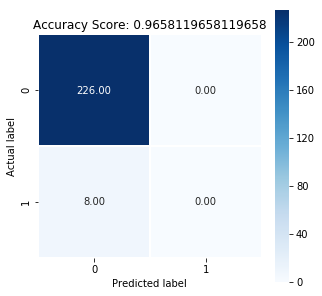

In [ ]:
evaluate_model_performance_valid_data(y_orig, y_pred)